# Import Libraries

In [18]:
!pip install tika
!pip install wordcloud
!pip install pyLDAvis gensim jupyter
import re
import os
import tika
import nltk
import locale
import gensim
import pyLDAvis
import numpy as np
from tqdm import tqdm
from tika import parser
from nltk.util import ngrams
from google.colab import drive
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import gensim.corpora as corpora
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pyLDAvis.gensim_models as gensimvis
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

nltk.download(["punkt_tab", "wordnet", "stopwords"])
drive.mount('/content/gdrive/')

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


# Reading Data

In [19]:
book_lists = [os.path.join("/content/gdrive/MyDrive/Colab Notebooks/LLM/Data", book) for book in os.listdir(path="/content/gdrive/MyDrive/Colab Notebooks/LLM/Data") if ".epub" in book]
book_lists

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):


['/content/gdrive/MyDrive/Colab Notebooks/LLM/Data/A Storm of Swords.epub',
 '/content/gdrive/MyDrive/Colab Notebooks/LLM/Data/A Clash of Kings.epub',
 '/content/gdrive/MyDrive/Colab Notebooks/LLM/Data/A Feast for Crows.epub',
 '/content/gdrive/MyDrive/Colab Notebooks/LLM/Data/A Dance With Dragons.epub',
 '/content/gdrive/MyDrive/Colab Notebooks/LLM/Data/A Game Of Thrones.epub']

In [20]:
book_length = {}

for book in book_lists:
  filename_wo_ext = os.path.splitext(os.path.basename(book))[0]
  filename_wo_ext_cleaned = filename_wo_ext.replace(" ", "_")
  globals()[filename_wo_ext_cleaned] = parser.from_file(filename=book, )["content"]
  book_length[filename_wo_ext] = len(globals()[filename_wo_ext_cleaned].split())

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):


# EDA

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):


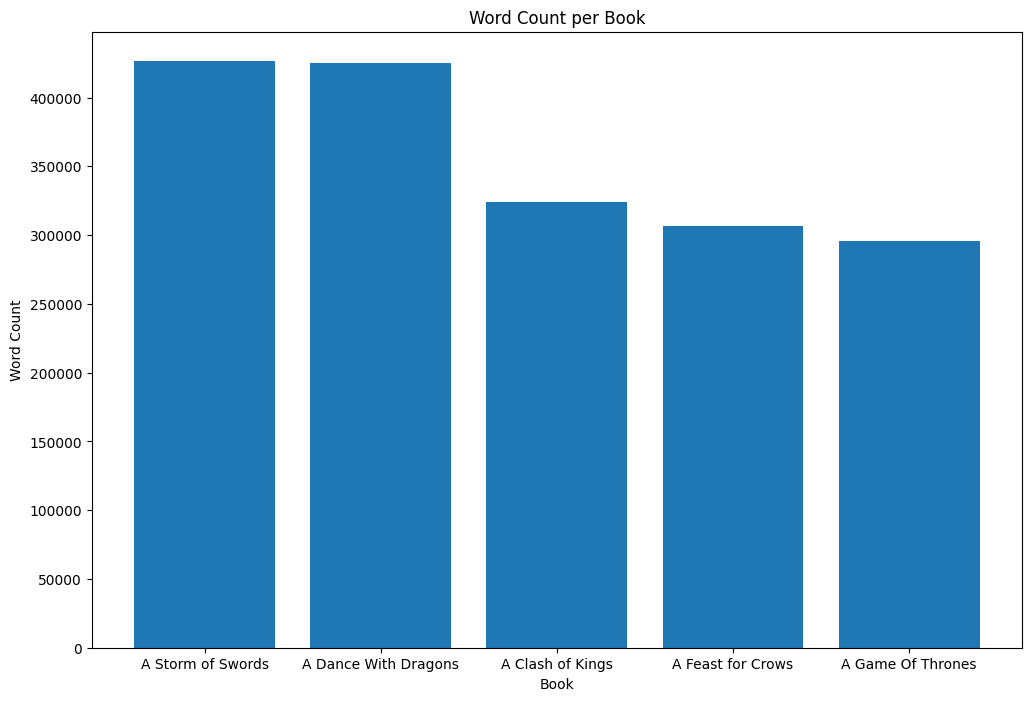

In [21]:
book_length = dict(sorted(book_length.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(12,8))
plt.bar(x=book_length.keys(), height=book_length.values())
plt.xlabel("Book")
plt.ylabel("Word Count")
plt.title("Word Count per Book");

### As the books progress, each book contains more words

In [22]:
combined_books = A_Storm_of_Swords + A_Dance_With_Dragons + A_Clash_of_Kings + A_Feast_for_Crows + A_Game_Of_Thrones
combined_books =  re.sub(r"[^A-Za-z0-9\s]","", re.sub(r"www.\S+", "", combined_books))

with open("/content/gdrive/MyDrive/Colab Notebooks/LLM/Data/combined_books.txt", "w") as f:
  f.write(combined_books)

combined_tokenized = word_tokenize(combined_books)
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

combined_lemmatize = [lemmatizer.lemmatize(word) for word in tqdm(combined_tokenized) if word not in stop_words]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):
100%|██████████| 1773591/1773591 [00:14<00:00, 119933.94it/s]


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):


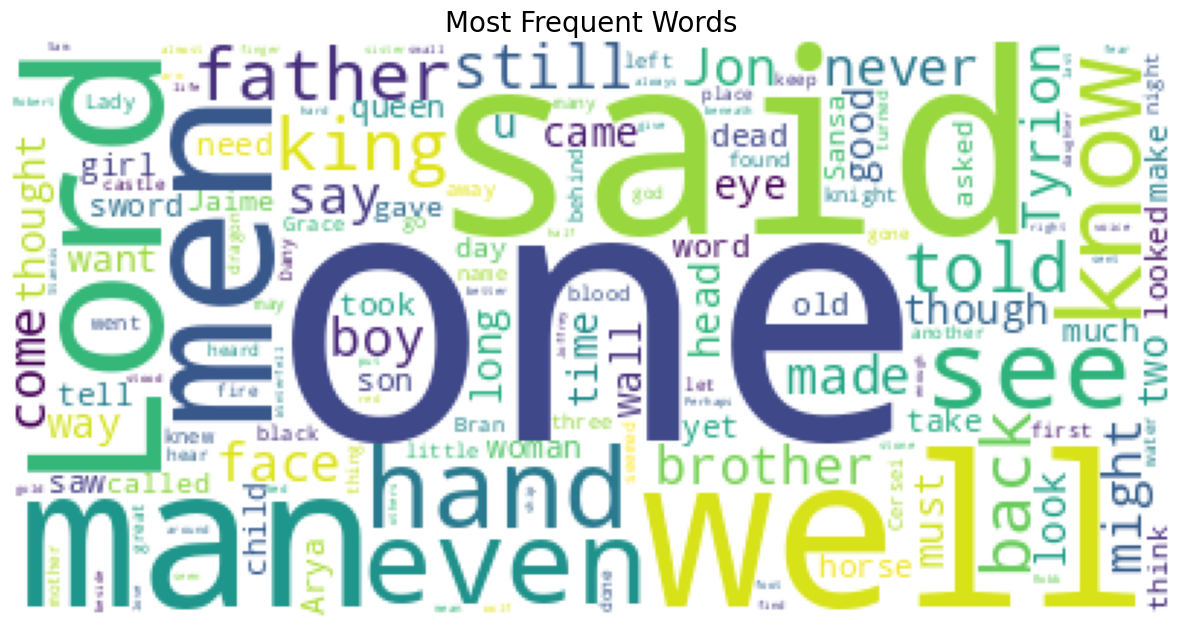

In [23]:
word_cloud = WordCloud(background_color="white").generate(" ".join(combined_lemmatize))
plt.figure(figsize=(15,8))
plt.axis("off")
plt.title("Most Frequent Words", fontsize=20)
plt.imshow(word_cloud);

### The most frequent words are said, one, man and Lord among others

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):


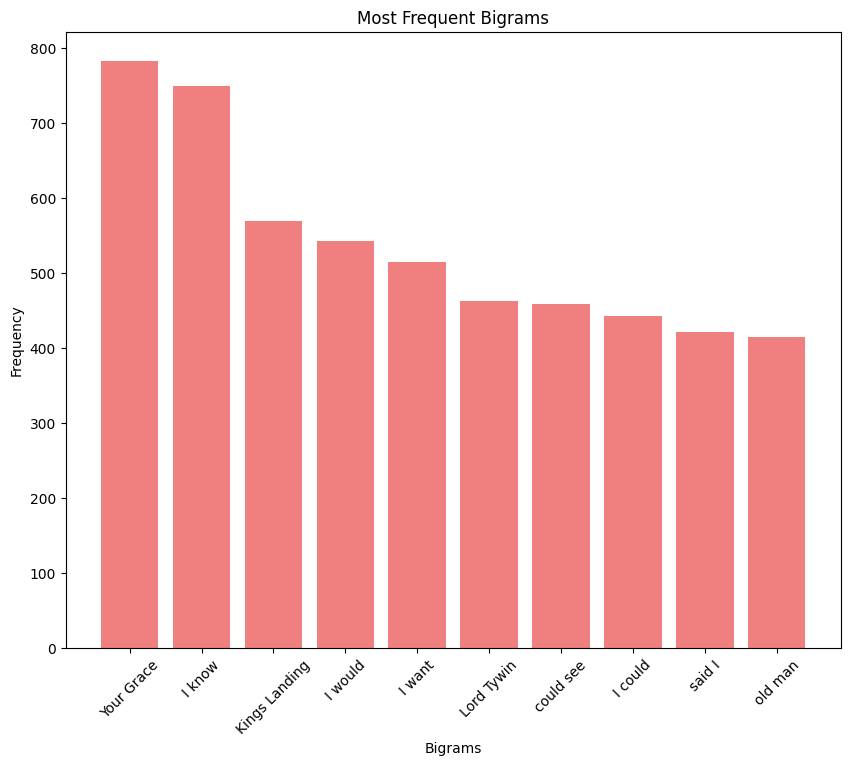

In [24]:
n = 2

bigrams = list(ngrams(combined_lemmatize, n=n))
top_bigrams = Counter(bigrams).most_common(10)
bigram_labels = [" ".join(bigram) for bigram,_ in top_bigrams]
bigram_freq = [freq for _, freq in top_bigrams]
plt.figure(figsize=(10,8))
plt.bar(bigram_labels, bigram_freq, color="lightcoral")
plt.xlabel("Bigrams")
plt.ylabel("Frequency")
plt.title("Most Frequent Bigrams")
plt.xticks(rotation=45)
plt.show();

### Being a big fan of Game of Thrones, it is not suprising that the top 10 bigrams are listed in the plot above

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):


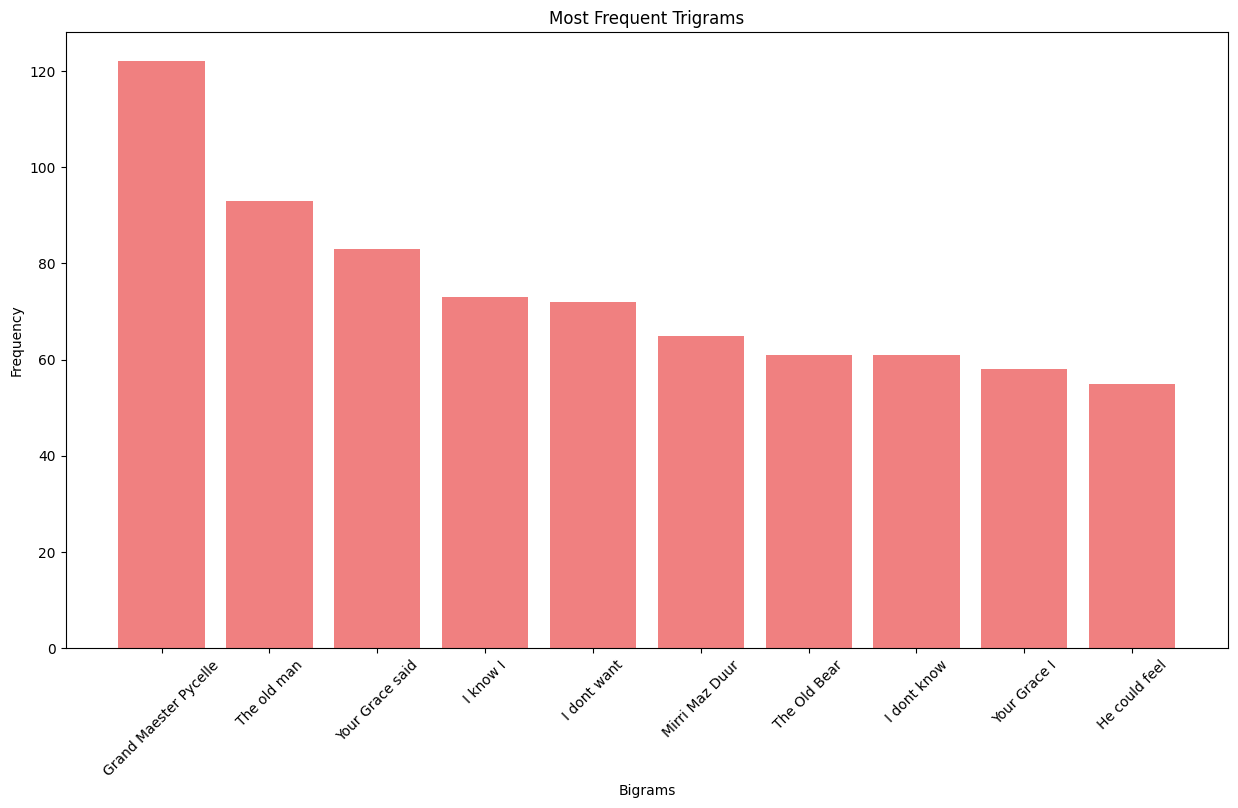

In [25]:
n = 3

trigrams = list(ngrams(combined_lemmatize, n=n))
top_trigrams = Counter(trigrams).most_common(10)
bigram_labels = [" ".join(trigram) for trigram,_ in top_trigrams]
trigram_freq = [freq for _, freq in top_trigrams]
plt.figure(figsize=(15,8))
plt.bar(bigram_labels, trigram_freq, color="lightcoral")
plt.xlabel("Bigrams")
plt.ylabel("Frequency")
plt.title("Most Frequent Trigrams")
plt.xticks(rotation=45)
plt.show();

### The same sentiment can be echoed for trigram.

In [26]:
combined_books = open("/content/gdrive/MyDrive/Colab Notebooks/LLM/Data/combined_books.txt",
                      "r",
                      encoding=locale.getpreferredencoding()).read().lower()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):


In [27]:
combined_tokenized = word_tokenize(combined_books)
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

combined_lemmatize = [lemmatizer.lemmatize(word) for word in tqdm(combined_tokenized) if word not in stop_words]
combined_books = " ".join(combined_lemmatize)
word_count = Counter(combined_lemmatize)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):
100%|██████████| 1773591/1773591 [00:07<00:00, 240744.07it/s]


In [28]:
top_ten_words = dict(sorted(word_count.items(), key=lambda x: x[1], reverse=True)[:10])
top_ten_words

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):


{'said': 8727,
 'lord': 8461,
 'would': 7026,
 'one': 6545,
 'ser': 6050,
 'could': 5075,
 'man': 4789,
 'king': 4345,
 'hand': 3915,
 'back': 3846}

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):


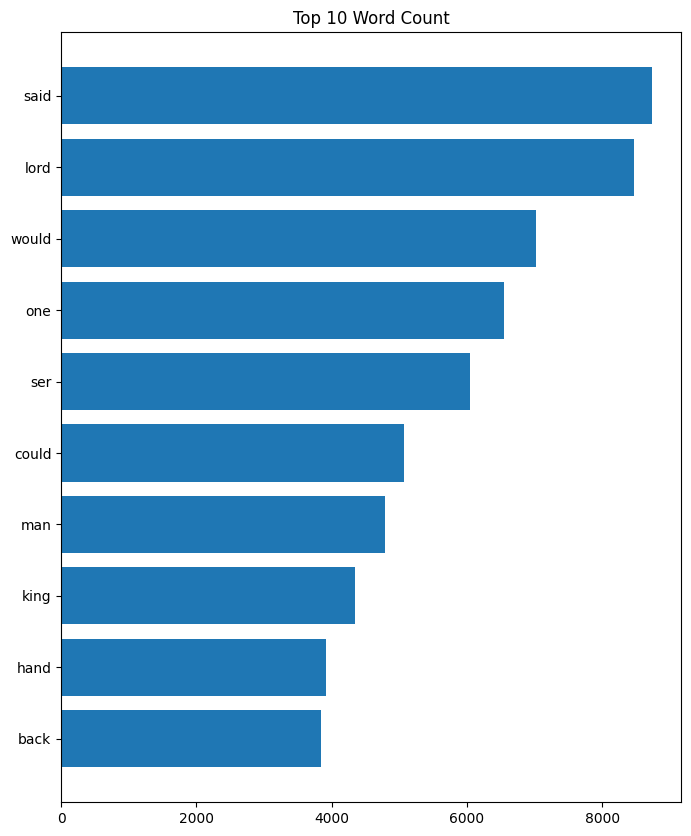

In [29]:
plt.figure(figsize=(8,10))
plt.barh(y=top_ten_words.keys(), width=top_ten_words.values())
plt.gca().invert_yaxis()
plt.title("Top 10 Word Count", fontsize=12);

In [30]:
books = [A_Storm_of_Swords, A_Dance_With_Dragons, A_Clash_of_Kings, A_Feast_for_Crows, A_Game_Of_Thrones]
books = [re.sub(r"[^A-Za-z0-9\s]", "", re.sub(r"www.\S+", "", book)) for book in books]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):


In [31]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

combined_books_lemmatize = [
    [lemmatizer.lemmatize(word.lower()) for word in word_tokenize(book) if word.lower() not in stop_words]
    for book in books]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):


In [32]:
id2word = corpora.Dictionary(combined_books_lemmatize)
dict(list(id2word.token2id.items())[:5])

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):


{'0060827': 0, '10th': 1, '15th': 2, '16th': 3, '2000': 4}

In [33]:
corpus = [id2word.doc2bow(book) for book in combined_books_lemmatize]
for i in range(5):
  print(corpus[i][:5])

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):


[(0, 1), (1, 1), (2, 2), (3, 1), (4, 2)]
[(14, 4), (15, 20), (16, 38), (17, 8), (19, 6)]
[(15, 4), (16, 11), (17, 1), (18, 1), (19, 13)]
[(14, 8), (15, 5), (16, 9), (17, 3), (18, 2)]
[(14, 5), (15, 3), (16, 8), (18, 6), (19, 6)]


In [34]:
num_topics = 5
random_state = 42
passes = 20
iterations = 1_000

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):


In [35]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=random_state,
                                       passes=passes,
                                       iterations=iterations)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):


In [36]:
pyLDAvis.enable_notebook()
lda_vis = gensimvis.prepare(topic_model=lda_model, corpus=corpus, dictionary=id2word)
pyLDAvis.display(lda_vis)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):


### Setting the number of topics to 5 shows no insight.

### I will double the number of topics.

In [37]:
num_topics = 10
random_state = 42
passes = 20
iterations = 1_000

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):


In [38]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=random_state,
                                       passes=passes,
                                       iterations=iterations)
pyLDAvis.enable_notebook()
lda_vis = gensimvis.prepare(topic_model=lda_model, corpus=corpus, dictionary=id2word)
pyLDAvis.display(lda_vis)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):


### Setting the number of topics to 10 shows insight.

In [41]:
model = Word2Vec(sentences=combined_books_lemmatize, vector_size=10, min_count=1, workers=8)
words = list(model.wv.key_to_index)
word_vectors = model.wv[words]
tsne = TSNE(init="pca",
            n_components=3,
            random_state=42,
            angle=0.9,
            perplexity=10,
            max_iter=250,
            n_jobs=-1)
word_embeddings = tsne.fit_transform(word_vectors)

np.save("/content/gdrive/MyDrive/Colab Notebooks/LLM/Data/word_embeddings.npy", word_embeddings)
with open("/content/gdrive/MyDrive/Colab Notebooks/LLM/Data/words.txt", "w") as f:
  for word in words:
    f.write(f"{word}\n")

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):
100%|██████████| 22410/22410 [00:01<00:00, 12872.44it/s]


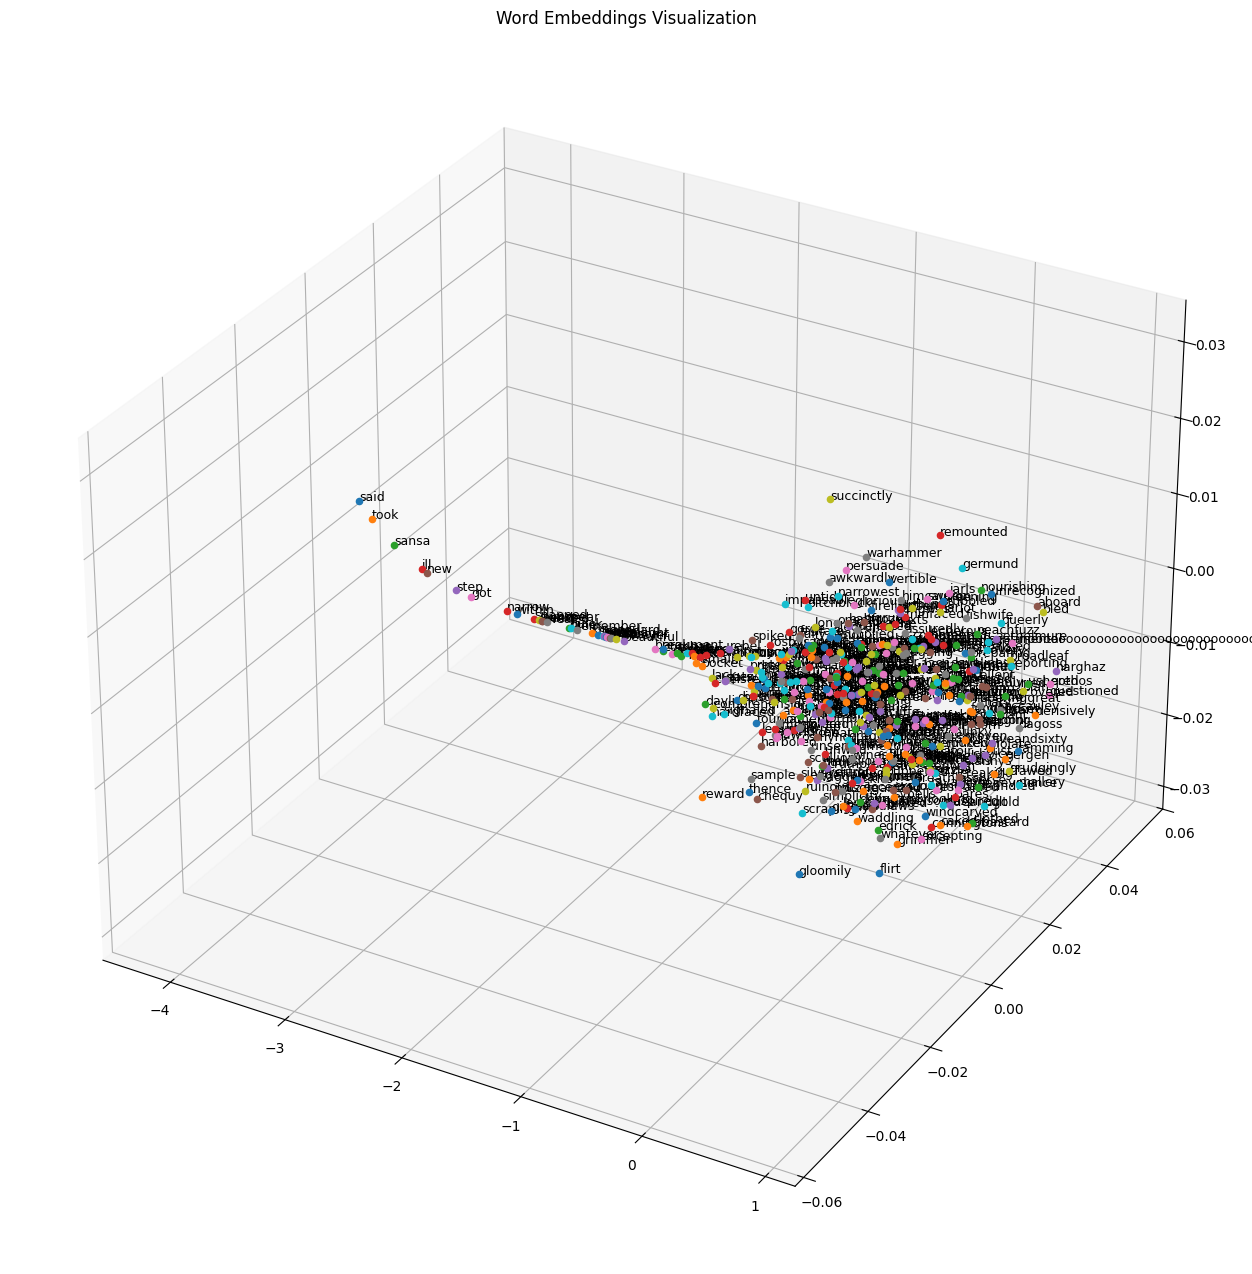

In [42]:
word_embeddings = np.load(file="/content/gdrive/MyDrive/Colab Notebooks/LLM/Data/word_embeddings.npy")
with open("/content/gdrive/MyDrive/Colab Notebooks/LLM/Data/words.txt",
          "r",
          encoding=locale.getpreferredencoding()) as f:
          contents = f.readlines()
words = [line.strip() for line in contents]

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection="3d")

for i, word in enumerate(tqdm(words)):
  if i % 50 == 0:
      ax.scatter(word_embeddings[i, 0],
                word_embeddings[i, 1],
                word_embeddings[i, 2])
      ax.text(word_embeddings[i, 0],
              word_embeddings[i, 1],
              word_embeddings[i, 2],
              word,
              fontsize=9)

ax.set_title("Word Embeddings Visualization")
plt.show()